# Preparation

In [1]:
import re
import pandas as pd 
import numpy as np
import urllib.request
import json
import requests
from bs4 import BeautifulSoup
import networkx as nx
from ast import literal_eval # transform data type
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from collections import Counter

import math
import statistics
from scipy import stats
import powerlaw
from PIL import Image

In [2]:
%matplotlib inline
import seaborn as sns
np.random.seed(sum(map(ord, "palettes")))

# Building the network

## Nodes: Finding champions by crawling

Data source:
- https://leagueoflegends.fandom.com/wiki/League_of_Legends_Wiki
- https://www.leagueoflegends.com/en-us/champions/<br>
LOL's official has a clear structure of champion list which is easy to get all champions' names by BeautifulSoup `find_all` function. We matched these names by finding labels with the same `class` in the HTML text file requested. 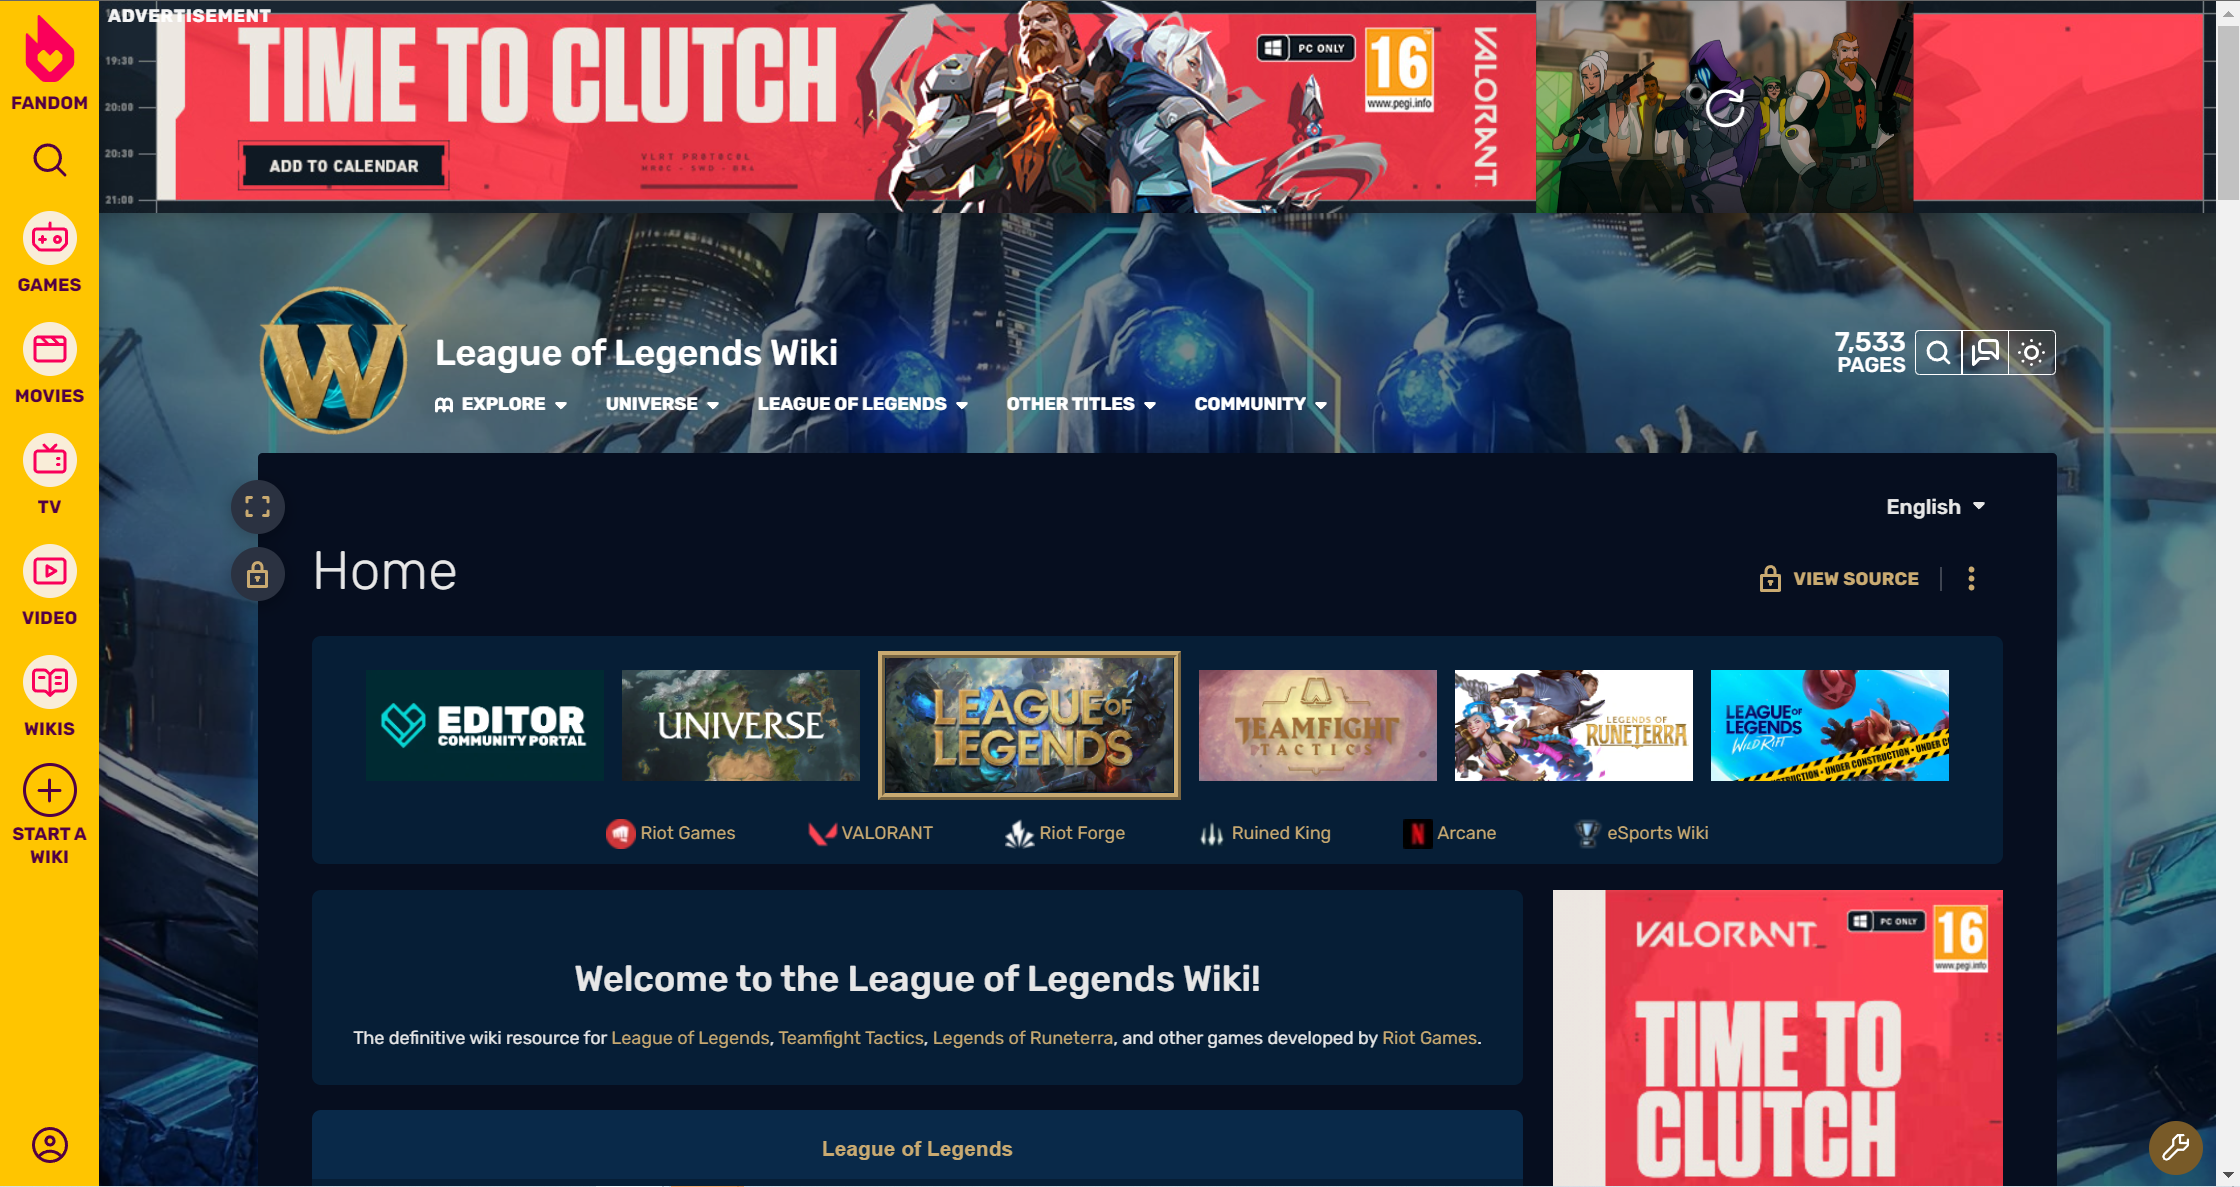

**Crawl champion names by BeautifulSoup from 'List of Champions' page on LOL official site**

In [3]:
url = 'https://www.leagueoflegends.com/en-us/champions/'
strhtml=requests.get(url)
soup=BeautifulSoup(strhtml.text,'lxml')
spans = soup.find_all(class_='style__Text-n3ovyt-3 gMLOLF')
list_of_champions = [i.text for i in spans]

In [4]:
print('There are',len(list_of_champions),'champions in LOL.')

There are 157 champions in LOL.


The dataframe below is afterprocess by already 

In [5]:
lol_df = pd.read_csv('./lol_df.csv',index_col=0)
lol_df.head()

Champion      Role    Faction  Community  Sentiment
0   Aatrox   Fighter  Runeterra          0   5.666132
1     Ahri      Mage      Ionia          3   5.674286
2    Akali  Assassin      Ionia          9   5.488501
3   Akshan  Marksman    Shurima          3   5.518679
4  Alistar      Tank  Runeterra          2   5.683729

## Node attributes

### champion class(role)

In [16]:
def get_role(champion):
    if champion == 'Dr. Mundo':
        champion = 'dr-mundo'
    elif champion == 'Nunu & Willump':
        champion = 'nunu'
    champion = champion.lower()
    # replace ' ', '.', '&', '''
    specialChars = '\'& . '
    for specialChar in specialChars:
        if specialChar in champion:
            champion = champion.replace(specialChar, '-')
    url = f'https://www.leagueoflegends.com/en-us/champions/{champion}/'
    strhtml=requests.get(url)
    soup=BeautifulSoup(strhtml.text,'lxml')
    spans = soup.select('#gatsby-focus-wrapper > div > section.style__Wrapper-sc-8gkpub-30.hvTntU > div.style__SectionInner-sc-8gkpub-3.drSgts > div.style__Dock-sc-8gkpub-5.eVSOFq > div.style__Info-sc-8gkpub-7.kTzPTF > div.style__Specs-sc-8gkpub-8.eBpPDq > ul > li.style__SpecsItem-sc-8gkpub-12.hsnFYj > div.style__SpecsItemValue-sc-8gkpub-15.kPaHxk')
    
    return spans[0].get_text()

In [17]:
role_list = []
for i in list_of_champions:
    try:
        role_list.append(get_role(i))
    except:
        print(i)

In [18]:
champion_role = {'Champion':list_of_champions,
                 'Role':role_list}
lol_df = pd.DataFrame(champion_role)
lol_df.head()

Champion      Role
0   Aatrox   Fighter
1     Ahri      Mage
2    Akali  Assassin
3   Akshan  Marksman
4  Alistar      Tank

In [42]:
print('LOL has',lol_df.Role.unique(),len(lol_df.Role.unique()),'types of roles.')

LOL has ['Fighter' 'Mage' 'Assassin' 'Marksman' 'Tank' 'Support'] 6 types of roles.


In [4]:
factions = ['Bandle City','Buhru','Blessed Isles','Bilgewater','Demacia','Freljord','Ionia','Ixtal','Noxus','Piltover','Runeterra','Shadow' 'Isles','Shurima','Targon','The Void','Void','Zaun']

In [140]:
# set a dictionary to store each champion's faction
champion_faction = {}
# get faction(regions)
def get_faction(faction):
    # get champion list according to given faction
    url = f'https://leagueoflegends.fandom.com/wiki/{faction}'
    strhtml=requests.get(url)
    soup=BeautifulSoup(strhtml.text,'lxml')
    spans = soup.select('#featured > span > a:nth-child(2)')
    # list of champions belonging to given faction 
    text = [line.get_text() for line in spans]
    for i in text:
        champion_faction[i] = faction

In [141]:
for i in factions:
    get_faction(i)

In [146]:
lol_df['Faction'] = lol_df['Champion'].apply(lambda x : champion_faction[x])

**Check the collection of data**

In [142]:
len(champion_faction) # There are 157 champions. We still have 5 champions without fraction

152

In [143]:
# find complement set of our dictionary to see which champion is homeless
# loop homeless champions assign their faction with Unknown 
for i in set(lol_df['Champion']) - set(champion_faction.keys()):
    champion_faction[i] = 'Unknown'

In [167]:
# print champions without fraction
unknown_champ = lol_df[lol_df['Faction']=='Unknown']['Champion']
print(unknown_champ)

38      Gwen
104    Senna
136      Vex
148     Yone
Name: Champion, dtype: object


_Among those homeless champions, they have ambiguous origins in wiki, but I could manually assign the faction based on League's official stories._

In [199]:
# these champions both lives or born in Freljord so assign them with Freljord
mask = lol_df['Champion'].isin(['Gragas','Gnar','Nunu & Willump'])
lol_df.loc[mask,'Faction'] = 'Freljord'

# Vex comes from Bandle city, however she cooperates with Viego and lives in Shadow Isles
mask2 = lol_df['Champion'].isin(['Vex','Gwen'])
lol_df.loc[mask2,'Faction'] = 'Shadow Isles' 

# Yone is Yasuo's brother so their hometown is the same, although Yone is thought to be lost but we can still assign he with Ionia
mask2 = lol_df['Champion'].isin(['Yone'])
lol_df.loc[mask2,'Faction'] = 'Ionia' 

mask2 = lol_df['Champion'].isin(['Senna'])
lol_df.loc[mask2,'Faction'] = 'Blessed Isles'

**Add to nodes**

In [5]:
# create an empty graph
G = nx.DiGraph()

In [6]:
for i in range(0,lol_df.shape[0]):
    G.add_node(lol_df.Champion.values[i],\
                 Role = lol_df.Role.values[i],
                 Faction = lol_df.Faction[i])

## Edges: Discover links between champions by API and Regrex

**Brief steps:**
>1. Query each champion page by API
>2. Save its json file to text
>3. Discover relationships in each character's text file by Regrex

First, I defined a function to help us get the query of each champion so we're able to download each champion's background story as text for later use(relationship mining,sentiment analysis).

In [7]:
#  get the query of each champion
def get_query(champion):
    if ' ' in champion:
        champion = champion.replace(" ", "_")
    elif 'é' or '\'' in champion:
        champion = urllib.parse.quote_plus(champion)
        
    # Get champions' names from List of Champions' page
    baseurl = "https://leagueoflegends.fandom.com/api.php?"
    action = "action=query"
    title = "titles={}".format(champion)
    content = "prop=extracts&exlimit=1&explaintext"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    return query

In [185]:
# save champion json page to text file 
def save_character_page(champion):
    query = get_query(champion)
    wikiresponse = urllib.request.urlopen(query, timeout=5)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikijson = json.loads(wikitext)
    
    # get right key from nested json file 
    pageid = list(wikijson['query']['pages'])[0]
    text = wikijson['query']['pages'][pageid]['extract']
    
    filename = f'./ChampionExplainText/{champion}.txt'
    with open(filename,mode='w',encoding='utf-8') as f:
        f.write(text)
        f.close()

In [128]:
# loop all champions. download all of pages to local
for character in list_of_champions:
    save_character_page(character)

**>>Save dataframe to csv so we can reuse**

In [200]:
lol_df.to_csv('./lol_df.csv')

### Discover relationships between champions

_Connect champions if their name shows in each other's background story_

In [8]:
for champion in lol_df.Champion:
    with open(f'./ChampionExplainText/{champion}.txt',mode='r',encoding='utf-8') as f:
        text = f.read()
        for i in lol_df.Champion:
            if i in text:
                if i!=Champion:
                    G.add_edge(champion,i)

### add edges between champions

In [9]:
def get_relationships(champion):
    url = f'https://leagueoflegends.fandom.com/wiki/{champion}'
    strhtml = requests.get(url)
    soup = BeautifulSoup(strhtml.text,'html.parser')
    data = soup.select("table tbody tr td div div a")
    # get tex within all HTML labels and concat to a list of audio scripts
    text = [line.get_text() for line in data]
    # remove '' element in list
    while '' in text:
        text.remove('')
    return text

In [10]:
for champion in lol_df.Champion:
    links = get_relationships(champion)
    for i in links:
        if i in lol_df.Champion.values:
            if i!=Champion:
                G.add_edge(champion,i)

In [11]:
# general info of our graph
nx.info(G).split('\n')

['Name: ',
 'Type: DiGraph',
 'Number of nodes: 157',
 'Number of edges: 1200',
 'Average in degree:   7.6433',
 'Average out degree:   7.6433']

**>>save our network to gml graph file so we can directly read it next time**

In [12]:
nx.write_gml(G, 'lolG.gml')

## Network visualization

In [164]:
# read Graph
G = nx.read_gml('lolG.gml')

### Degree distribution

In [169]:
# finding values and value counts for distribution plot
in_deg = list(dict(G.in_degree()).values())
value_in, value_in = np.unique(in_deg, return_counts=True)

out_deg = list(dict(G.out_degree()).values())
value_out, count_out = np.unique(out_deg, return_counts=True)

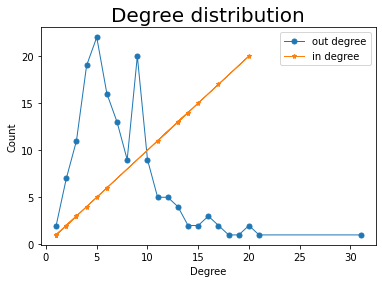

In [172]:
plt.title("Degree distribution", size=20)
plt.plot(value_out, count_out, linewidth=1, marker="o", markersize=5)
plt.plot(value_in, value_in, linewidth=1, marker="*", markersize=5)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend(['out degree','in degree'])
plt.show()

Most of champions have 20 around out-degree. About 2 champions have out-degree more than 30.

Top 5 most connected champions:

In [201]:
sorted(dict(G.out_degree()).items(),key=lambda x:x[1],reverse=True) [0:5] # based on out-degree

[('Viego', 31), ('Irelia', 21), ('Diana', 20), ('Pyke', 20), ('Graves', 19)]

In [165]:
sorted(dict(G.in_degree()).items(),key=lambda x:x[1],reverse=True) [0:5] # based on in-degree

[('Viego', 28), ('Vi', 22), ('Irelia', 21), ('Diana', 20), ('Graves', 20)]

Top 5 loneliness champions:

In [203]:
sorted(dict(G.out_degree()).items(),key=lambda x:x[1],reverse=False) [0:5] # based on out-degree

[('Amumu', 1), ('Rammus', 1), ('Annie', 2), ('Dr. Mundo', 2), ('Gnar', 2)]

In [204]:
sorted(dict(G.in_degree()).items(),key=lambda x:x[1],reverse=False) [0:5] # based on in-degree

[('Nunu & Willump', 0), ('Amumu', 1), ('Annie', 1), ('Bard', 1), ('Rammus', 1)]

### Role Analysis

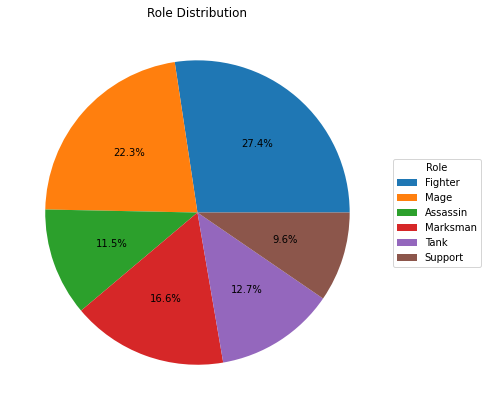

In [153]:
roles = lol_df.Role.unique()
role_counts = dict(lol_df.Role.value_counts())
data = [role_counts[i] for i in roles]

fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(data,autopct='%.1f%%')

ax.set_title('Role Distribution')

# Adding legend
ax.legend(wedges, roles,
          title ="Role",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

_About half of champions are Fighters and Mages in the universe of League of Legends. The third largest group is Marksmen. Tank and Assassin ranks below, while Support account for the least proportion of champions._

### Champion Network - Colored based on Faction

In [14]:
largest = max(nx.weakly_connected_components(G)) #Obtaining the Giant Connected Component.
LG = G.subgraph(largest) #Creating graph of the Giant connected component.
UGG = nx.to_undirected(LG) #Giant Connected component undirected.

In [16]:
from fa2 import ForceAtlas2
forceatlas2 = ForceAtlas2()
pos = forceatlas2.forceatlas2_networkx_layout(UGG) 

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1175.56it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.06  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


In [78]:
sizemap = [nx.degree(UGG, node)*50 for node in UGG.nodes()]
colors = list(sns.color_palette("muted", lol_df.Faction.nunique()))# create color pattern by sns palette
faction_color_zip =  dict(zip(lol_df.Faction.unique(),colors))

In [115]:
colormap= []
for i in UGG.nodes:
    color_code = faction_color_zip[lol_df[lol_df['Champion']==i].iloc[0]['Faction']]
    colormap.append(color_code)

In [116]:
# cmap
node_options = {
    'node_color':colormap,
    'node_size':sizemap,
    'alpha':0.8,
}

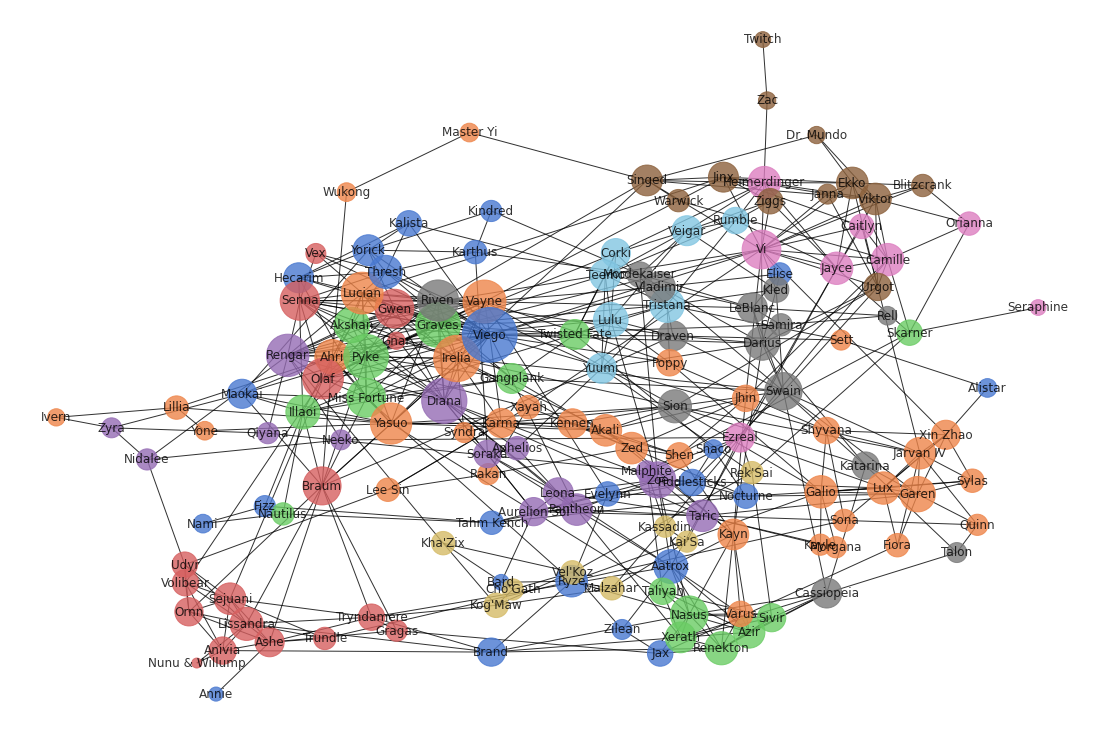

In [205]:
plt.figure(figsize=(15,10))
nx.draw(UGG,pos,with_labels=True,**node_options)

Text(0.5, 1.0, 'Population Distribution of LOL Factions')

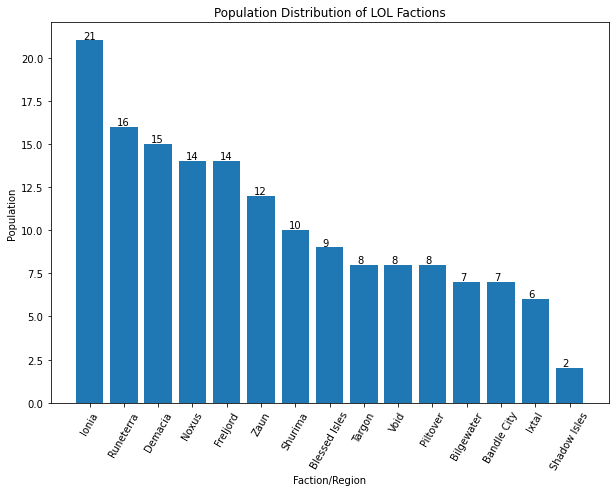

In [226]:
faction_n_ppl = dict(lol_df.Faction.value_counts())
x = [i for i in faction_n_ppl.keys()]
y = [i for i in faction_n_ppl.values()]

plt.figure(figsize=(10,7))
plt.bar(x, y)
plt.xticks(range(len(lol_df.Faction.unique())), x, rotation = '60')
for i in range(len(x)):
    plt.text(i-0.2,y[i]+0.1,y[i]) # add value labels
plt.ylabel('Population')
plt.xlabel('Faction/Region')
plt.title('Population Distribution of LOL Factions')

- It is obvious that Ionia has the most champions. 
- It could be a great background place for League's story if we're gonna make a big movie. 
- Runeterra, Demacia, Noxus and Freljord where have around 15 champions might also be good options. 

**However, an appporiate number of sentimental characters and good plots are the most important factors to an intriguing movie.
The complex and conflict relationships between characters can always attract audiences' eyes 
Thus, community partition is the answer! Each champion's sentiment would also be analyzed to see if they have the quality to be a role people would love or hate..**

### Community Network
 Previously we save our network as gml graph file and then we could make use of <a href='https://gephi.org/'>Gephi</a> to have a nice visualization.

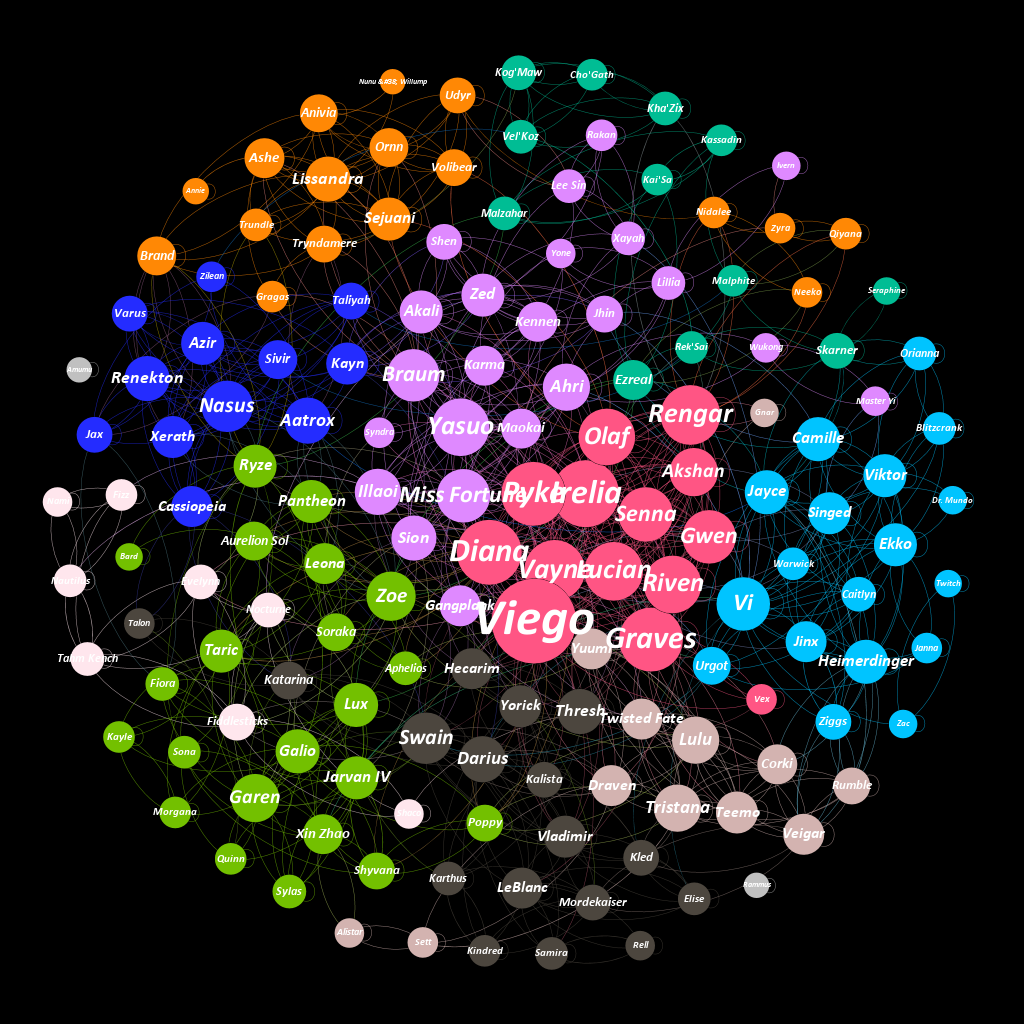

# Sentiment Analysis

## Get audio scripts of each champion

In [9]:
def get_audioScript(champion):
    url = f'https://leagueoflegends.fandom.com/wiki/{champion}/LoL/Audio'
    strhtml = requests.get(url)
    soup = BeautifulSoup(strhtml.text,'html.parser')
    data = soup.select('#mw-content-text > div.mw-parser-output > ul > li > i')
    data2 =  soup.select('#mw-content-text > div > div > div> ul > li > i')

    # get text within all HTML labels and concat to a list of audio scripts
    text = [line.get_text() for line in data]
    text2 = [line.get_text() for line in data2]
    text.extend(text2)
    if champion == 'Nunu':
        filename = f'./ChampionAudioText/Nunu & Willump.txt'
        with open(filename,mode='w',encoding='utf-8') as f:
            f.write(str(text))
            f.close()
    else:
        filename = f'./ChampionAudioText/{champion}.txt'
        with open(filename,mode='w',encoding='utf-8') as f:
            f.write(str(text))
            f.close()

In [10]:
for i in list_of_champions:
    if i == 'Nunu & Willump':
        get_audioScript('Nunu')
    else:
        get_audioScript(i)    

**Now we have got all champions' audio text, next step is to analyse their sentiment.**

## TF-IDF based on background story

In [6]:
page_path = r"./ChampionExplainText/"

In [7]:
from nltk.tokenize import WhitespaceTokenizer

def remove_multiple_words(description):
    split_characters_name =[]
    
    for i in lol_df.Champion :
        if ' ' in i:
            h = i.split(' ')
            if len(h)<=3:
                for i in range(len(h)):
                    split_characters_name.append(h[i])
            else:
                split_characters_name.append(h[0])
        else:
            split_characters_name.append(i)
            
            
    word_tokenizer = WhitespaceTokenizer()
    raw_words_list = word_tokenizer.tokenize(description)
    
    words_list = [i for i in raw_words_list if i not in split_characters_name]
    h = ' '.join(words_list)
    return h

In [8]:
#preprocess explian text
champions_explain_words={}
pattern ="==+.*==+" 


split_characters_name =[]
for i in lol_df.Champion :
    if ' ' in i:
        h = i.split(' ')
        if len(h)<=3:
            for i in range(len(h)):
                split_characters_name.append(h[i])
        else:
            split_characters_name.append(h[0])
    else:
        split_characters_name.append(i)
        
        
for champion in lol_df.Champion:
    with open(page_path + champion + '.txt',encoding = 'utf-8')as f:
        
        description = f.read()
        
        words = re.sub(pattern,'',description)
        
        raw_words = remove_multiple_words(words)

        
        word_tokenizer = WhitespaceTokenizer()#split word by space
        raw_words_list = word_tokenizer.tokenize(raw_words)
        
        new_text = ' '.join(raw_words_list)
        
        word_tokenizer = WordPunctTokenizer()
        words_list = word_tokenizer.tokenize(new_text)
        
        re_names_words = [i for i in words_list if i not in split_characters_name]
        
        stop_words = stopwords.words('english')
        punctuation_list = string.punctuation
        words_list = [w.lower() for w in re_names_words if w not in stop_words and any(c.isalpha() for c in w )]
        
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words_list ]
        words_again_draw_stop_words = [w for w in words if w not in stop_words]
        champions_explain_words[champion] = words_again_draw_stop_words
     
        

In [9]:
def calculate_IDF(word,dic):
    i = 0
    for key,value in dic.items():
        if word in value:
            i+=1
        
    IDF = math.log(len(dic) / i+1)
    
    return IDF

In [10]:
TF_IDF_explain = {}

for key,value in champions_explain_words.items():
    TF_IDF_dic={}
    words = nltk.Text(value)
    frequency = nltk.FreqDist(words)
    frequency_value = frequency.most_common()
    for i in range(len(frequency_value)):
        h = calculate_IDF(frequency_value[i][0],champions_explain_words)
        TF_IDF = (frequency_value[i][1]/len(value)) * h
        TF_IDF_dic[frequency_value[i][0]]= TF_IDF
    TF_IDF_explain[key] = TF_IDF_dic 

## Vader Score

In [15]:
vader = pd.read_csv('./vader_lexicon.txt',sep='\t',
            header=None,names=['TOKEN', 'MEAN-SENTIMENT-RATING', 'STANDARD DEVIATION', 'RAW-HUMAN-SENTIMENT-RATINGS'])

In [16]:
#process the raw audion text fot the vader sentiment
champion_dialogues={}
for champion in lol_df.Champion:
    with open(f'./ChampionAudioText/{champion}.txt',encoding = 'utf-8')as f:
        description = f.read()
        sentence_raw_list = literal_eval(description)
        sentence_list=[]
        for sentence in sentence_raw_list:
            sentence = re.sub("[\"]","",sentence)
            if '\'' in sentence:
                sentence = sentence.replace('\\', '')
                sentence_list.append(sentence)
            else:
                sentence_list.append(sentence)
        champion_dialogues[champion] = sentence_list 

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vader_champion_score = {}
# loop each characters
for i in champion_dialogues.keys():
    sentences = champion_dialogues[i]
    avg_vs = 0
    # calculate sentiment for each dialogue of this character
    sentence_count = 0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        # extract the compound score we only need it
        avg_vs+=vs['compound']
        sentence_count+=1
    vader_champion_score[i] = avg_vs/sentence_count

In [22]:
counter_vader_champion_score = Counter(vader_champion_score)
order_vader_champion_score = dict(counter_vader_champion_score.most_common())

In [23]:
order_vader_champion_score

{'Amumu': 0.28495,
 'Annie': 0.18147567567567566,
 'Zoe': 0.16605032679738557,
 'Taric': 0.1651830601092897,
 'Gwen': 0.160663698630137,
 'Zilean': 0.15682380952380953,
 'Braum': 0.15665376344086018,
 'Twisted Fate': 0.15256666666666666,
 'Kennen': 0.141645,
 'Kassadin': 0.1321142857142857,
 'Wukong': 0.12804212962962971,
 'Corki': 0.1269952380952381,
 'Neeko': 0.12593496932515336,
 'Lillia': 0.12296987179487182,
 'Jayce': 0.1224421052631579,
 'Yuumi': 0.12240734463276837,
 'Seraphine': 0.11689684014869901,
 'Elise': 0.112042,
 'Shaco': 0.10691428571428573,
 'Janna': 0.10605749999999999,
 'Poppy': 0.10098260869565215,
 'Karma': 0.10094444444444445,
 'Dr. Mundo': 0.0974705329153605,
 'Aurelion Sol': 0.09232835249042153,
 'Draven': 0.09026382978723402,
 'Taliyah': 0.0901586666666667,
 'Jax': 0.08761609195402302,
 'Evelynn': 0.08725548387096778,
 'Vladimir': 0.0838,
 'Ziggs': 0.08127297297297296,
 'Singed': 0.08091785714285715,
 'Quinn': 0.07775686274509805,
 'Caitlyn': 0.0763879844961241

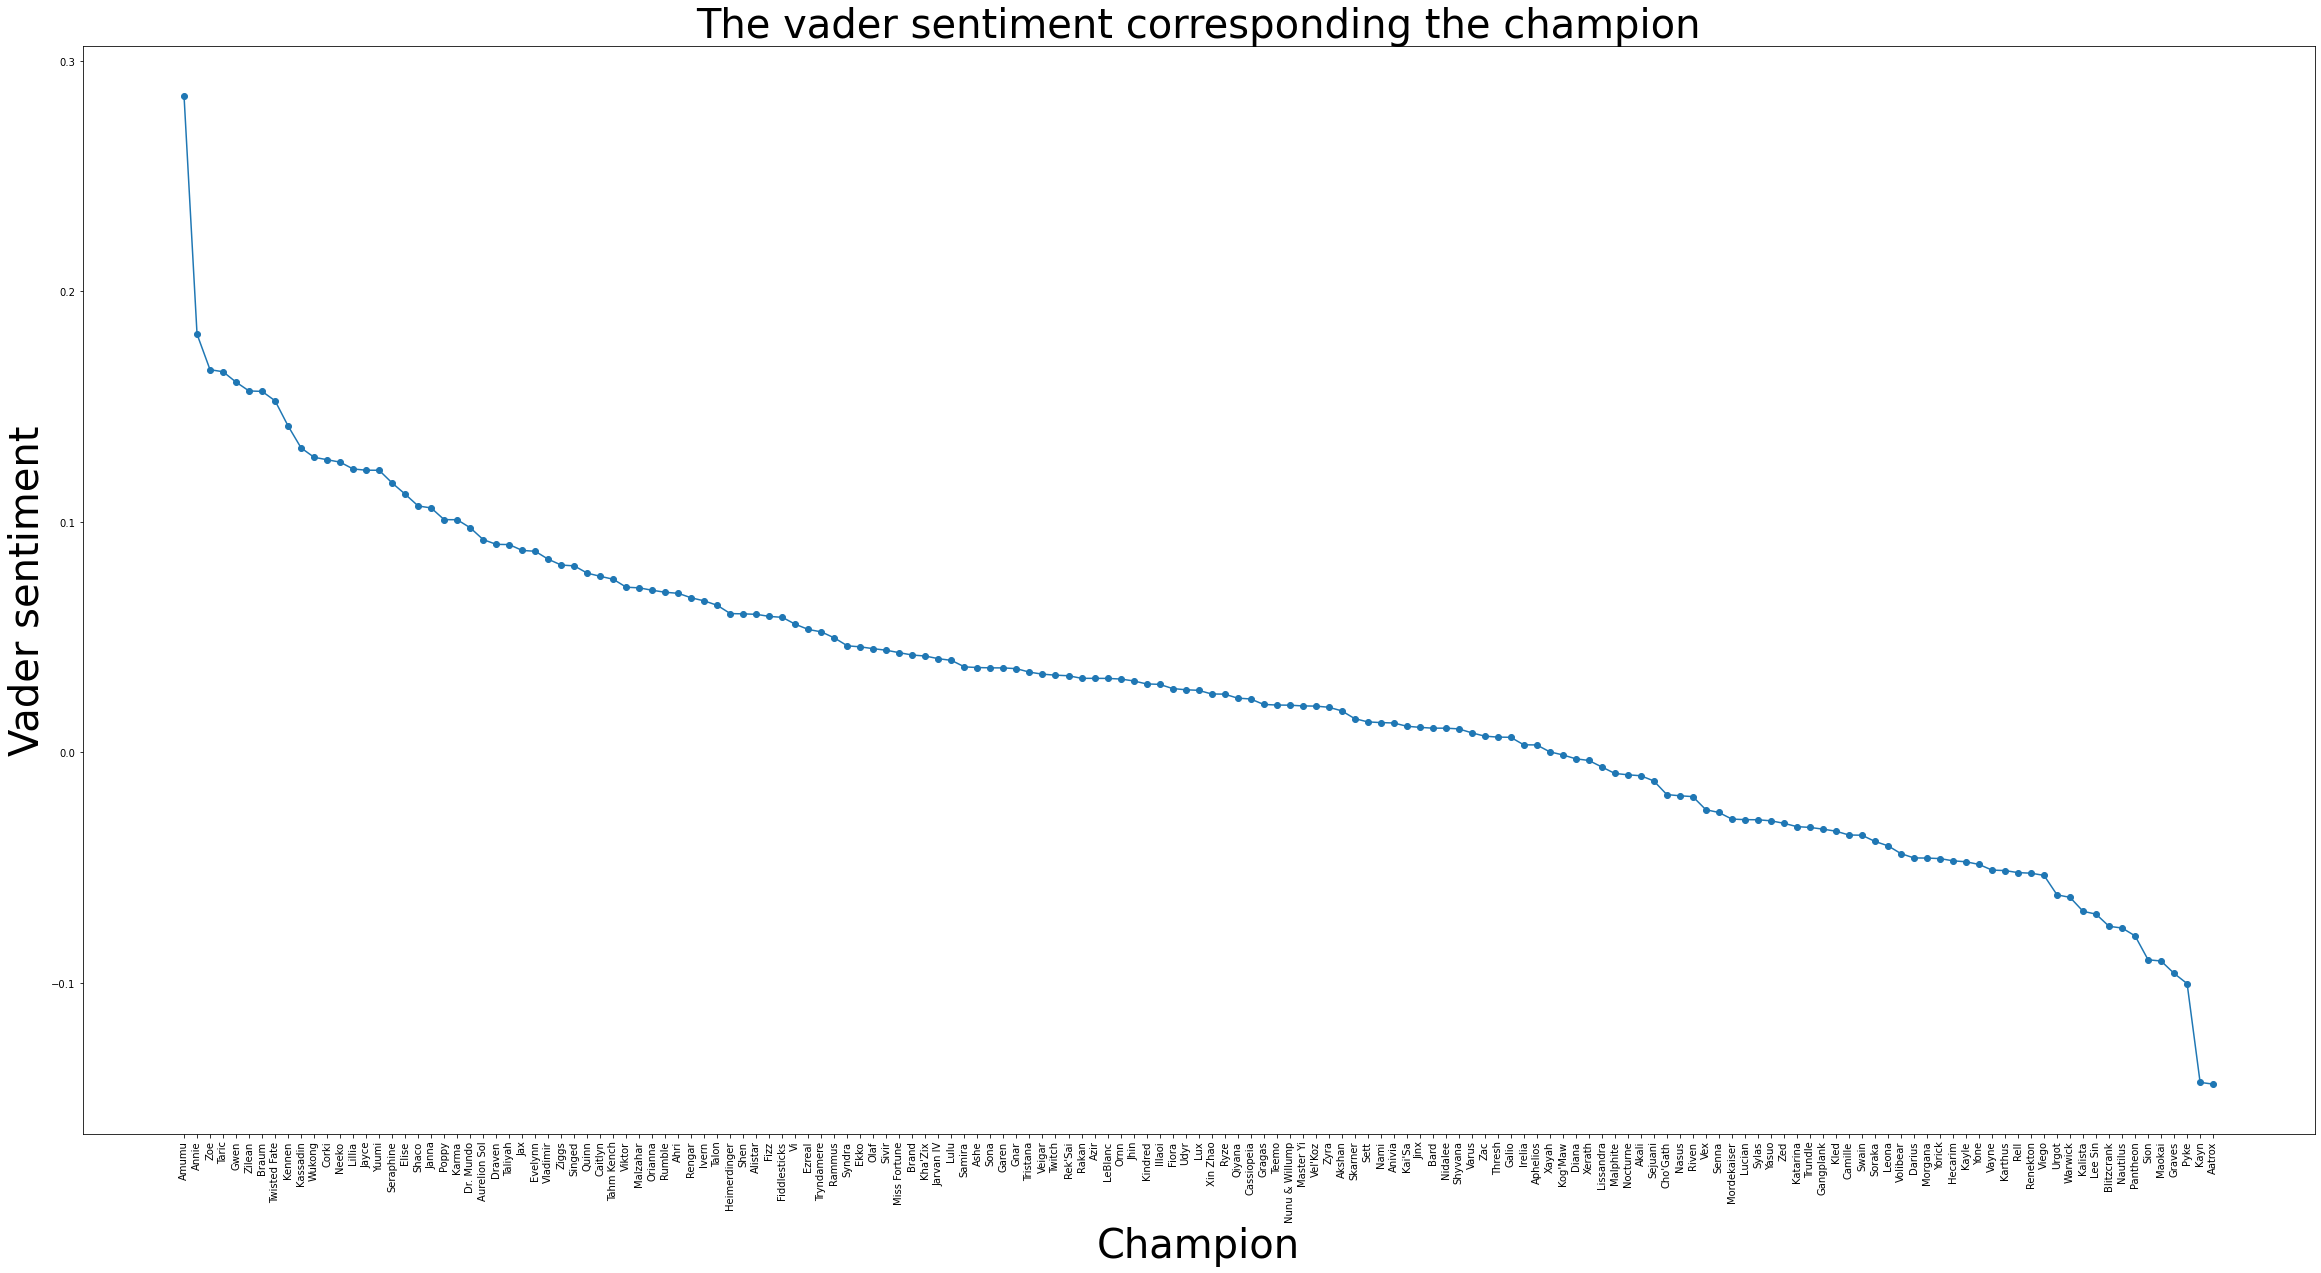

In [370]:
x = [i for i in order_vader_champion_score.keys()]
y = [w for w in order_vader_champion_score.values()]

fig = plt.figure(figsize=(40,20))


_ = plt.errorbar(x, y, fmt='-o')
plt.xticks([i for i in range(len(order_vader_champion_score))], x, rotation = '90')
_ = plt.ylabel('Vader sentiment',fontsize = 40)
_ = plt.xlabel('Champion',fontsize = 40)
_ = plt.title('The vader sentiment corresponding the champion',fontsize = 40)

# Communities Analysis

## Name Communities

In [43]:
df_vader_sentiment = pd.DataFrame(list(vader_champion_score.items()),columns = ['Champion','Vader Sentiment'])
df_vader_sentiment.set_index('Champion', inplace=True)
lol_df=pd.merge(lol_df, df_vader_sentiment[['Vader Sentiment']], on='Champion', how='inner')

In [45]:
# write to csv for convenience use
lol_df.to_csv('./lol_df.csv')

In [46]:
nr_communities= max(lol_df['Community'])
com_sent_mean = [lol_df[lol_df["Community"]==i]["Vader Sentiment"].mean() for i in range(nr_communities)]

com_stdev =[] # store sentiment standard deviation of each community to list
for i in range(nr_communities):
    if len(lol_df[lol_df["Community"]==i]["Vader Sentiment"])>1:
        com_stdev.append(statistics.stdev(lol_df[lol_df["Community"]==i]["Vader Sentiment"]))
    else:
        com_stdev.append(0)

In [47]:
def get_community_colors(n):
    return ['#%02x%02x%02x' % tuple(np.random.randint(256, size = 3)) for _ in range(n)]
colors = get_community_colors(nr_communities)

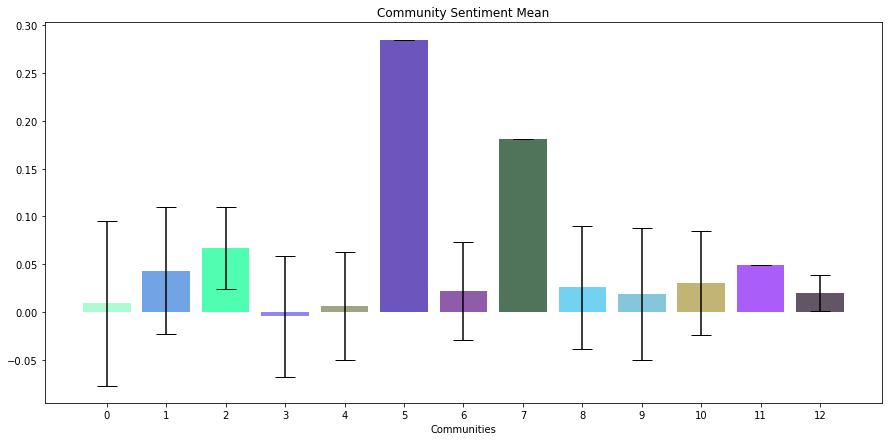

In [48]:
plt.figure(figsize=(15,7))
plt.bar(range(nr_communities),com_sent_mean, yerr=com_stdev,align='center', alpha=0.7, ecolor='black', capsize=10, color = colors)
plt.xticks(range(nr_communities),range(nr_communities))
plt.xlabel("Communities")
plt.title('Community Sentiment Mean')
plt.show()

This is our previous community sentiment distribution graph which based on labMIT.txt
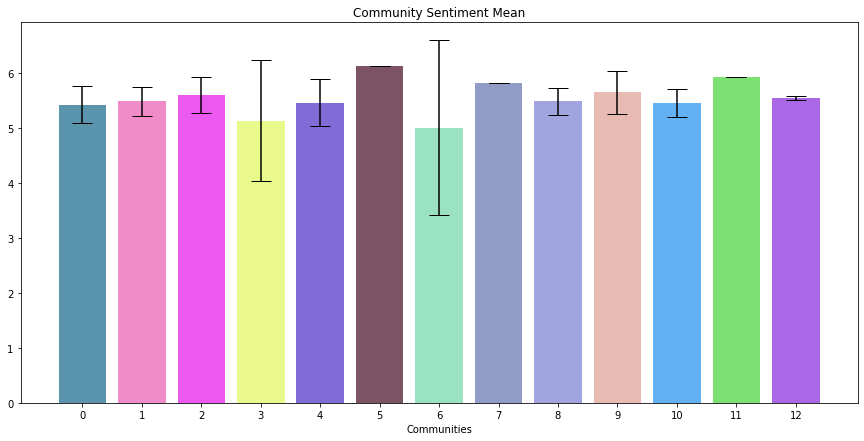

# WordCloud

**To better understand the characteristics of each fraction in league**, we draw wordcloud to describe their theme words.

## Define wordcloud functions

Get mask picture:To draw beautiful wordclouds, we first download champion's image and then transformed it to mask for our wordcloud.<br>
_**Def a function to download champion picture as mask**_

In [26]:
def get_pic(champion):
    url = f'https://leagueoflegends.fandom.com/wiki/{champion}'
    strhtml=requests.get(url)
    soup=BeautifulSoup(strhtml.text,'lxml')
    spans = soup.select('aside figure a img')
    pic_address = spans[0]['src']
    r = requests.get(pic_address)
    with open(f"./images/{champion}.jpg", "wb") as f:
        f.write(r.content)

In [27]:
def transform_mask(champion):
    mask = np.array(Image.open(f"./images/{champion}.jpg"))
    mask = mask[:,:,0] # transform 3d image to 2d for easier visualization
    
    def transform_format(val):
        if val.all()== 0:
            return 255
        else:
            return val

    # Transform your mask into a new one that will work with the function
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format,mask[i]))
    
    return transformed_mask

_**Def a function to get theme color of image**_

In [28]:
def get_image_colors(champion):
    mask = np.array(Image.open(f"./images/{champion}.jpg"))
    image_colors  = ImageColorGenerator(mask,default_color = [0.6,0.6,0.6])
    return image_colors

_**Def a function to draw wordcloud**_

In [29]:
def generate_wordcloud(champion):
    get_pic(champion)

    freqdict = TF_IDF_explain[champion]
    
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='white',
        contour_width=3,
        contour_color='silver',
        mask=transform_mask(champion), 
        collocations=False,
    ).generate_from_frequencies(freqdict)
    
    plt.figure(figsize=(4,10))
    plt.imshow(wordcloud.recolor(color_func=get_image_colors(champion)),interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Wordcloud of Champions

- The standard deviation of each champion's sentiment shows how strong this champion's emotion ups and downs, which indicates their dramatic personalities to an extend. 
- In fact, viewers or readers of artwork are more likely to be attracted by characters who bear the pain of destiny, trying to avenge or laugh with those with good personalities bringing happiness and luck to others. 
- Based on this point, by visualizing their theme words through wordcloud, we can find interesting facts about them, which would be helpful to offer suggestions when Riot Games considering which character to include in their league movie or TV series.

**The top 5 champions with positive sentiments**

In [30]:
top5_pos_champ = list(order_vader_champion_score.keys())[0:5]

Amumu


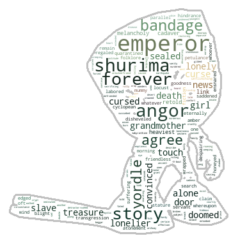

Annie


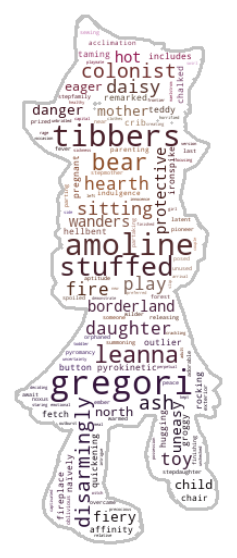

Zoe


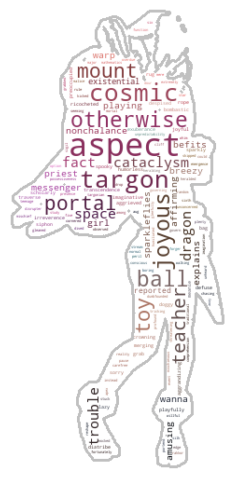

Taric


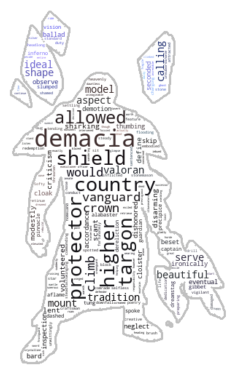

Gwen


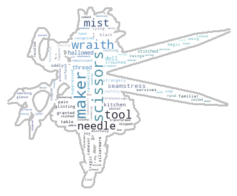

In [379]:
for i in top5_pos_champ:
    print(i)
    generate_wordcloud(i)

**The top 5 champions with negative sentiments**

In [31]:
top_5_neg_champ = list(order_vader_champion_score.keys())[-5:]

Maokai


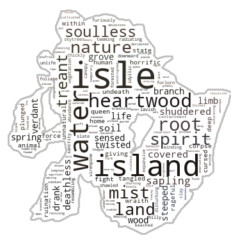

Graves


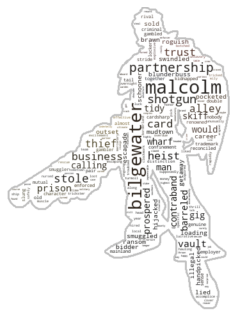

Pyke


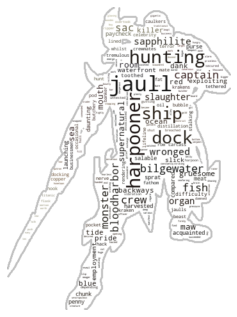

Kayn


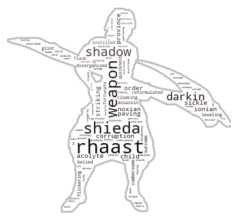

Aatrox


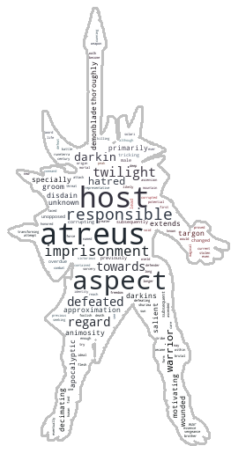

In [392]:
for i in top_5_neg_champ:
    print(i)
    generate_wordcloud(i)

## Wordcloud of Communities

**Generate wordclouds of top 5 sentimentally dinstinctive communities.**<br>


In [49]:
#  find the values of top3 sentimentally dinstinctive communities and use values to index communities
top5_std = sorted(com_stdev,reverse=True)[0:5]
com_num = [com_stdev.index(i) for i in top5_std]

Community 0 ['Aatrox', 'Azir', 'Brand', 'Cassiopeia', 'Jax', 'Kayn', 'Nasus', 'Renekton', 'Sivir', 'Taliyah', 'Varus', 'Xerath', 'Zilean']


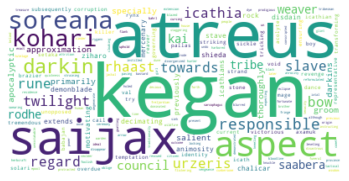

Community 9 ['Akali', 'Jhin', 'Karma', 'Kennen', 'Lee Sin', 'Rakan', 'Shen', 'Sion', 'Syndra', 'Xayah', 'Zed']


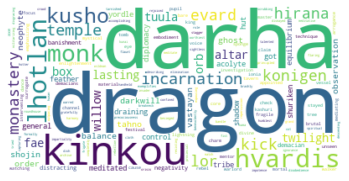

Community 1 ['Blitzcrank', 'Caitlyn', 'Camille', 'Dr. Mundo', 'Ekko', 'Janna', 'Jayce', 'Jinx', 'Master Yi', 'Orianna', 'Seraphine', 'Singed', 'Skarner', 'Urgot', 'Vi', 'Viktor', 'Warwick', 'Wukong']


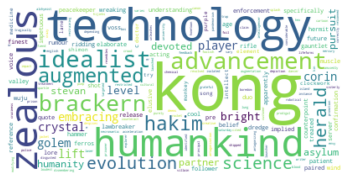

Community 8 ['Aphelios', 'Aurelion Sol', 'Bard', 'Fiora', 'Galio', 'Garen', 'Jarvan IV', 'Kayle', 'Leona', 'Lux', 'Morgana', 'Pantheon', 'Poppy', 'Quinn', 'Ryze', 'Shyvana', 'Sona', 'Soraka', 'Sylas', 'Taric', 'Xin Zhao', 'Zoe']


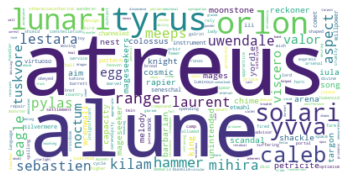

Community 3 ['Ahri', 'Akshan', 'Diana', 'Gangplank', 'Graves', 'Gwen', 'Hecarim', 'Illaoi', 'Irelia', 'Kalista', 'Lillia', 'Lucian', 'Miss Fortune', 'Olaf', 'Pyke', 'Rengar', 'Riven', 'Senna', 'Thresh', 'Vayne', 'Vex', 'Viego', 'Yasuo', 'Yone', 'Yorick']


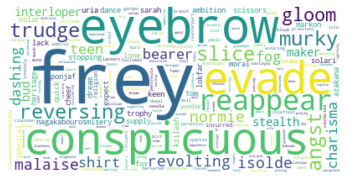

In [50]:
for i in com_num:
    freqdict = {}
    for j in lol_df[lol_df["Community"]==i]['Champion']:
        freqdict.update(TF_IDF_explain[j])
        
    print('Community',i,list(lol_df[lol_df["Community"]==i]['Champion']))  
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='white',
        contour_width=3,
        contour_color='silver', 
        collocations=False,
    ).generate_from_frequencies(freqdict)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Findings

Previously, we detect the top 5 most positive or negative champions. We also find communities with richful sentiments and dinstinct emotion waves. It's time to combine those results to see if there would be amazing findings as muse for a birth of great movie.

In [51]:
for i in top5_pos_champ+top_5_neg_champ:
    num = lol_df[lol_df["Champion"]==i]['Community'].item()
    if num in com_num: # if the most emotional champion is in the top5 sentimental communities, output the community number
        print(i,num)

Zoe 8
Taric 8
Gwen 3
Graves 3
Pyke 3
Kayn 0
Aatrox 0


**As a result, the top sentimental champions all occur in two of communities with largest standard deviation**, which are:<br>
- Community 3 ['Ahri', 'Akshan', 'Diana', 'Gangplank', 'Graves', 'Gwen', 'Hecarim', 'Illaoi', 'Irelia', 'Kalista', 'Lillia', 'Lucian', 'Miss Fortune', 'Olaf', 'Pyke', 'Rengar', 'Riven', 'Senna', 'Thresh', 'Vayne', 'Vex', 'Viego', 'Yasuo', 'Yone', 'Yorick'] 
- Community 0 ['Aatrox', 'Azir', 'Brand', 'Cassiopeia', 'Jax', 'Kayn', 'Nasus', 'Renekton', 'Sivir', 'Taliyah', 'Varus', 'Xerath', 'Zilean']
- Community 8 ['Aphelios', 'Aurelion Sol', 'Bard', 'Fiora', 'Galio', 'Garen', 'Jarvan IV', 'Kayle', 'Leona', 'Lux', 'Morgana', 'Pantheon', 'Poppy', 'Quinn', 'Ryze', 'Shyvana', 'Sona', 'Soraka', 'Sylas', 'Taric', 'Xin Zhao', 'Zoe']

By the way, Viego is the most connected character. This shows the plot of community is centred around him and champions connected with him.<br> **First,Let's take a brief look at his background story.**
>Once ruler of a long-lost kingdom, Viego perished over a thousand years ago when his attempt to bring his wife back from the dead triggered the magical catastrophe known as the Ruination. Transformed into a powerful, unliving wraith tortured by an obsessive longing for his centuries-dead queen, Viego now stands as the Ruined King, controlling the deadly Harrowings as he scours Runeterra for anything that might one day restore her, and destroying all in his path as the Black Mist pours endlessly from his cruel, broken heart.

**He sounds like a powerful but desperate king falling deeply love with his queen and would rather corrupt to bring his dead wife's life back at any cost. A good guy becomes an villian, other champions try to stop him. OKay! I would buy a ticket for it(not fan's filter)<br>**

<big>In conclusion, through network analysis, sentiment analysis, inspection on wordcloud, we have right to say Viego's story would be a wonderful choice to be the plot for an intriguing LOL movie, which would  win audience's love!</big>

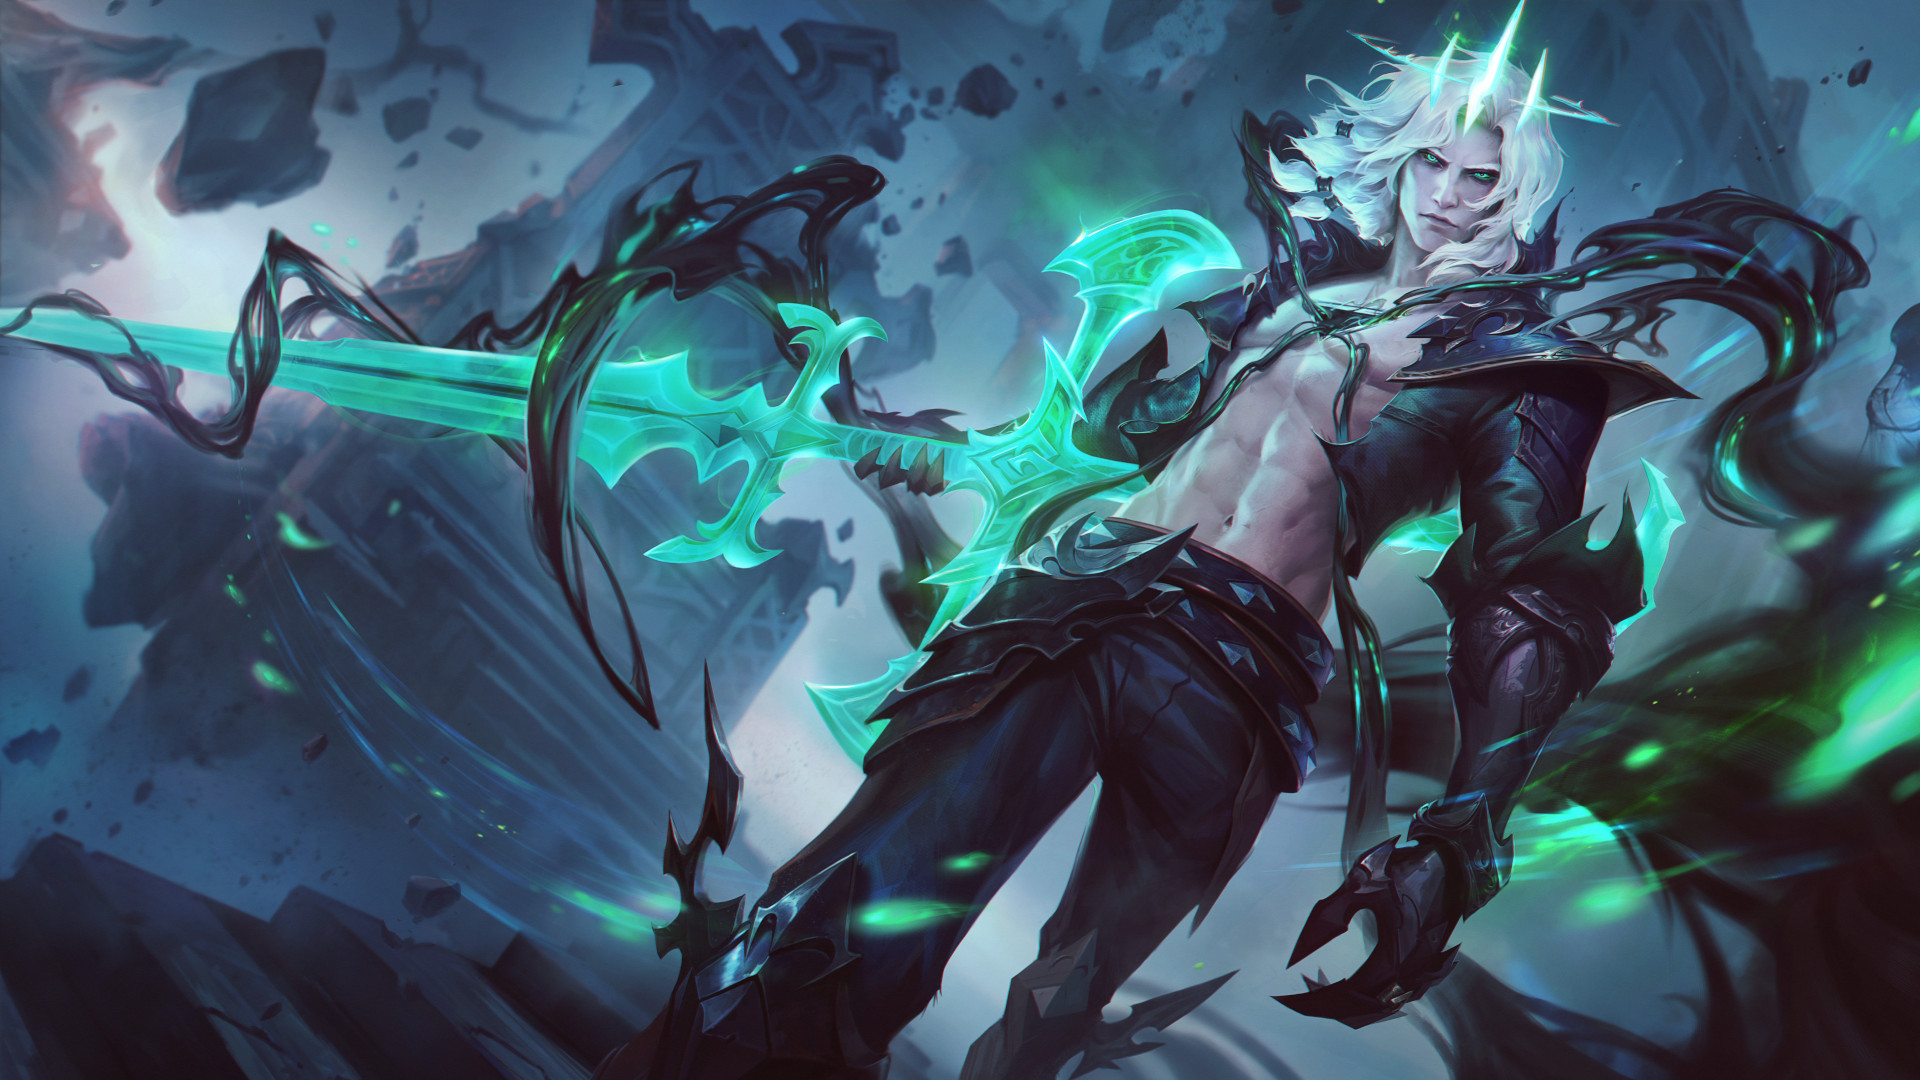